In [ ]:
from google.colab import files

# Upload the dataset ZIP file manually
uploaded = files.upload()


Saving archive.zip to archive.zip


In [ ]:
import zipfile
import os

zip_path = "/content/archive.zip"  # Change name if yours is different
extract_path = "/content/garbage_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)  # Check folders


['TrashType_Image_Dataset']

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_data_dir = "/content/garbage_dataset/TrashType_Image_Dataset"
base_dir = "/content/garbage_dataset_split"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create folders again if not exist
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Split images per class
categories = os.listdir(original_data_dir)

for category in categories:
    category_path = os.path.join(original_data_dir, category)
    images = os.listdir(category_path)

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split_type, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_folder = os.path.join(base_dir, split_type, category)
        os.makedirs(split_folder, exist_ok=True)

        for img in split_imgs:
            src = os.path.join(category_path, img)
            dst = os.path.join(split_folder, img)
            shutil.copy(src, dst)

print("✅ Dataset re-split into train, val, test.")



✅ Dataset re-split into train, val, test.


In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# ⚙️ Prepare the Data
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/garbage_dataset_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/garbage_dataset_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# =========================
# 🧠 Load MobileNetV2 Base
# =========================
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

# =========================
# 🧱 Build the Model Head
# =========================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# =========================
# ⚙️ Compile the Model
# =========================
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# =========================
# ⏱️ Setup Callbacks
# =========================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# =========================
# 🚀 Train the Model
# =========================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, lr_reduce]
)


Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4168 - loss: 1.4904 - val_accuracy: 0.7672 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7179 - loss: 0.7568 - val_accuracy: 0.7884 - val_loss: 0.5610 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7687 - loss: 0.6066 - val_accuracy: 0.8069 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7927 - loss: 0.5425 - val_accuracy: 0.8175 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8337 - loss: 0.4716 - val_accuracy: 0.8122 - val_loss: 0.4820 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8051 - loss: 0.5222 - val_accuracy: 0.8148 - val_loss: 0.4758 - learning_rate: 0.0010
Epoch 7/20


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


Found 2416 images belonging to 7 classes.
Found 905 images belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.2543 - loss: 1.9500 - val_accuracy: 0.6099 - val_loss: 1.1541
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5452 - loss: 1.2227 - val_accuracy: 0.7215 - val_loss: 0.8524
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6184 - loss: 1.0527 - val_accuracy: 0.7635 - val_loss: 0.7034
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6806 - loss: 0.8869 - val_accuracy: 0.7878 - val_loss: 0.6157
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7188 - loss: 0.8019 - val_accuracy: 0.8088 - val_loss: 0.5674
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7139 - loss: 0.7854 - val_accuracy: 0.8199 - val_loss: 0.5284
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7408 - loss: 0.6879 - val_accuracy: 0.8320 - val_loss: 0.4988
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7572 - loss: 0.6640 - val_accuracy: 0.8409 - v

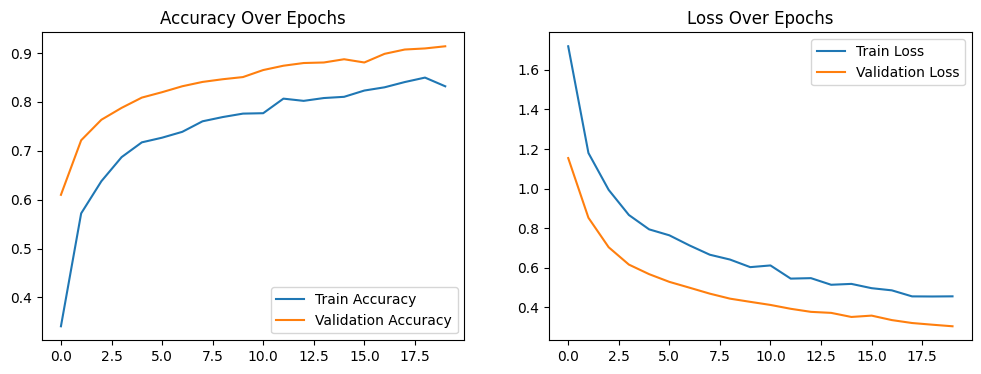

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()


In [ ]:
model.save("/content/garbage_classifier_mobilenetv2.h5")
print("✅ Model saved.")


✅ Model saved.


In [ ]:
from tensorflow.keras.models import load_model

# Load the model you saved earlier
model = load_model("/content/garbage_classifier_mobilenetv2.h5")
print("✅ Model loaded.")


✅ Model loaded.


Saving glass_002.jpg to glass_002.jpg
📸 Uploaded file: glass_002.jpg


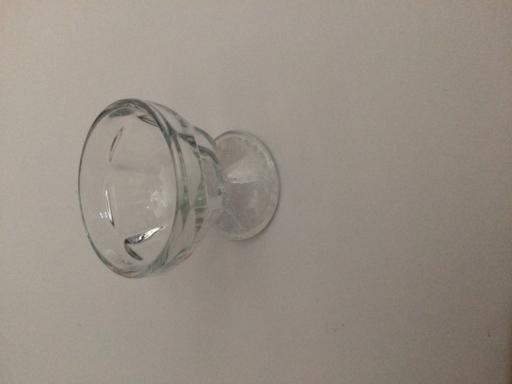

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


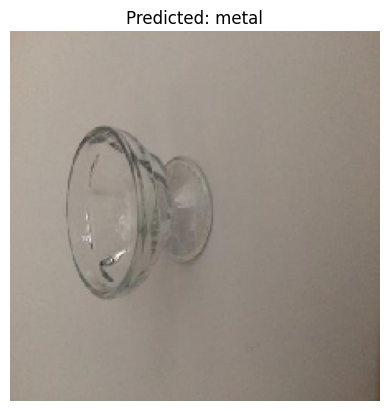

In [34]:
from google.colab import files
from IPython.display import display
import PIL.Image

uploaded = files.upload()

for fn in uploaded.keys():
    print(f"📸 Uploaded file: {fn}")
    img = PIL.Image.open(fn)
    display(img)

    # Predict
    preprocess_and_predict(fn, model, class_indices)


In [35]:
train_generator.class_indices


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [38]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"📊 Final Val Accuracy: {val_acc:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8777 - loss: 0.3810
📊 Final Val Accuracy: 0.87


In [39]:
model.save("garbage_classifier_mobilenetv2.h5")


In [40]:
from keras.models import load_model

# Load your trained model
model = load_model("garbage_classifier_mobilenetv2.h5")
print("✅ Model loaded.")


✅ Model loaded.


Saving metal_001.jpg to metal_001 (1).jpg
Saving metal_002.jpg to metal_002.jpg
Saving metal_003.jpg to metal_003.jpg
Saving metal_004.jpg to metal_004.jpg
Saving metal_005.jpg to metal_005 (1).jpg
Saving metal_006.jpg to metal_006.jpg
Saving metal_007.jpg to metal_007.jpg
Saving metal_011.jpg to metal_011.jpg
Saving metal_012.jpg to metal_012.jpg
Saving metal_013.jpg to metal_013.jpg
Saving metal_014.jpg to metal_014.jpg
Saving metal_015.jpg to metal_015.jpg
Saving metal_016.jpg to metal_016.jpg
Saving metal_017.jpg to metal_017.jpg
Saving metal_021.jpg to metal_021.jpg
Saving metal_022.jpg to metal_022.jpg
Saving metal_023.jpg to metal_023.jpg
Saving metal_024.jpg to metal_024.jpg
Saving metal_025.jpg to metal_025.jpg
Saving metal_026.jpg to metal_026.jpg
Saving metal_027.jpg to metal_027.jpg
Saving metal_031.jpg to metal_031.jpg
Saving metal_032.jpg to metal_032.jpg
Saving metal_033.jpg to metal_033.jpg
Saving metal_034.jpg to metal_034.jpg
Saving metal_035.jpg to metal_035.jpg
Savi

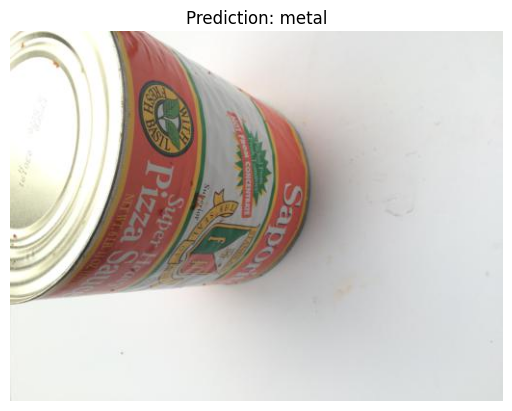

In [49]:
from google.colab import files
from keras.preprocessing import image
import numpy as np
import PIL
import matplotlib.pyplot as plt

# Step 1: Upload an image
uploaded = files.upload()

# Step 2: Get the uploaded filename
filename = list(uploaded.keys())[0]
print(f"✅ Uploaded: {filename}")

# Step 3: Preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # resize to model's input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array = img_array / 255.0  # normalize
    return img_array

# Step 4: Predict and Show
def predict_image(img_path, model):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Get class labels
    class_labels = list(train_generator.class_indices.keys())  # assumes train_generator was used earlier
    predicted_label = class_labels[predicted_class_index]

    # Show image and prediction
    img = PIL.Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

# Step 5: Call prediction
predict_image(filename, model)


In [51]:
from keras.models import load_model
model = load_model('garbage_classifier_mobilenetv2.h5')  # e.g. model.h5


In [52]:
from google.colab import files
files.download('garbage_classifier.h5')


FileNotFoundError: Cannot find file: garbage_classifier.h5

In [53]:
model.save('garbage_classifier.h5')


In [54]:
from google.colab import files
files.download('garbage_classifier.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
from google.colab import files
files.download('garbage_classifier.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>